###### 2014 ImageNet : GoogLeNet
GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进
这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。
毕竟，以前流行的网络使用小到 1×1 ，大到 11×11 的卷积核。
本文的一个观点是，有时使用不同大小的卷积核组合是有利的。
在本节中，我们将介绍一个稍微简化的GoogLeNet版本

### 7.4.1. Inception块
在GoogLeNet中，基本的卷积块被称为Inception块（Inception block）。
这很可能得名于电影《盗梦空间》（Inception），因为电影中的一句话“我们需要走得更深”（“We need to go deeper”）。
![Inception块](imgs/7_4_1Inception块1.png)

如图所示。
Inception块由4条并行路径组成。
前三条路径使用 1 x 1、 3 x 3、 5 x 5的卷积层，从不同的空间大小中提取信息。
中间两条路径在输入上执行1 x 1卷积，以减少通道数，从而降低模型的复杂性。
第四条路径使用3 x 3的max pooling，然后1 x 1卷积来改变通道数。

##### 这4条路经都使用合适的填充来使得输入和输出的高和宽一致
最后我们把每条线路的输出
##### ！在通道维度的连结，
并构成Inception 块的输出。
##### 在Inception块中，通常调整的超参数是每层输出通道数。

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

![GooLeNet](imgs/7_4_2GoogLeNet模型1.png)

如图所示，GooLeNet一共使用9个Inception块
和
##### 全局平均池化层的堆叠来生成其估计值。
Inception块之间的最大池化可降低维度
第一个模块类似于AlexNet和LeNet，
Inception块的组合从VGG继承，
##### 全局平均池化避免了在最后使用全连接层

In [7]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [8]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

第三个模块串联两个完整的Inception块。
第一个Inception块的输出通道数为64 + 128 + 32 + 32 = 256。 2 ： 4 ： 1 ： 1
第二个和第三个路径首先将输入通道的数量分别减少到 96/192=1/2 和 16/192=1/12 ，然后接第二个卷积层。
第二个Inception块的输出通道数增加到 128+192+96+64=480 ，四个路径之间的输出通道数量比为 128:192:96:64=4:6:3:2 。 第二条和第三条路径首先将输入通道的数量分别减少到 128/256=1/2 和 32/256=1/8 。

In [9]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [10]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [11]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [12]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


training on cuda:0


RuntimeError: DataLoader worker (pid(s) 17256, 9016, 18784, 3796) exited unexpectedly

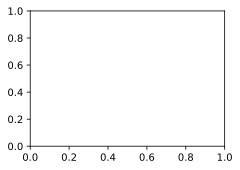

In [13]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())